# Primer on the Epoch of Reionization

In this notebook I attempt to show the general *mathematical and computational* idea behind simulating the EoR using excursion set formalism. This approach is computationally much cheaper compared to the radiation transfer simulation. It was first proposed to be used in this ontext by [Fulanetto et al. (2004)](https://ui.adsabs.harvard.edu/#abs/2004ApJ...613....1F/abstract). Since then it was refined and modified in different ways. Probably the most popular implementation of this approach is [21cmFAST](https://ui.adsabs.harvard.edu/#abs/2011MNRAS.411..955M/abstract).

If you need a general introduction to the physics of reionization, you can start with [Pritchard & Loeb (2012)](https://ui.adsabs.harvard.edu/#abs/2012RPPh...75h6901P/abstract). In this notebook we consider the simplest regime, when:
* Spin temperature is completely coupled to the kinetic temperature.
* Gas is heated homogeneously.

I plan to make a separate notebook on comic dawn (when the spin temperature couples with gas temperature) later.

___


## Table of contents

The notebook consists of three major sections.

* We start with [preparation](#Preparation), where we use FastPM code to quickly generate the Initical Conditions (ICs) and an evolved density field.

* In [painting the EoR](#Painting-the-EoR) we start to post-process the density field in order to mimic the ionization fronts.
 * The [simplest case](#Simplest-model), where only the ICs are used.
 * [More advanced case with halos](#Model-with-halos).

* Then, we explore a few more advanced additions to the model, which [brake spherical symmetry](#Breaking-spherical-symmetry).
 * [Filaments](#Filaments)
 * [Bubbles in Lagrangian space](#)
 * [Stochastic component](#Stochastic-component) from asymmetry of ionization escape fraction and bursty star formation.

# Preparation

We need to start with a density field. We are going to use FastPM code, which is DM only code that allows to quickly generate a DM density realization. See ... for the details.

In [310]:
%%html
<style>
body {
  counter-reset: section subsection;
}

h1 {
  counter-reset: subsection;
}

h1:before {
    counter-increment: section;
    content: "Section " counter(section) ". ";
}

h2:before {
    counter-increment: subsection;
    content: counter(section) "." counter(subsection) " ";
}
// add your CSS styling here
</style>

## Installing components

You need to preinstall the following components.

* FastPM, nbodykit

The easiest (and probably the only proper way) is to install them through anaconda. If you are not familiar with anaconda -- it is a convenient tool for creating virtual Python environments. It simplifies installation of packages (instead of pip or easy_install).

See detailed instructions [here](https://github.com/rainwoodman/fastpm), but essentially all you need to do is:
~~~~
conda create -n cfastpm
conda activate cfastpm

conda install -c bccp cfastpm nbodykit
conda install scipy matplotlib
~~~~

Then you need to add this new installation to the list of your Jupyther notebook kernels:
~~~~
source activate cfastpm
python -m ipykernel install --name cfastpm
source deactivate
~~~~


In [371]:
# we start with importing all necessary components
%matplotlib inline

import numpy as np
from numpy import sin, cos, pi

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

from scipy.stats import rankdata, norm

# FastPM related libraries to work with snapshots
from nbodykit.source.catalog.file import BigFileCatalog
from nbodykit.source.mesh import BigFileMesh
from nbodykit.cosmology import Planck15
from nbodykit.cosmology import EHPower

from skimage import measure


/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/nbodykit/cosmology/power/linear.py:228: FutureWarning: NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'
  warnings.warn("NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'", FutureWarning)


Text(0,0.5,'P(k)')

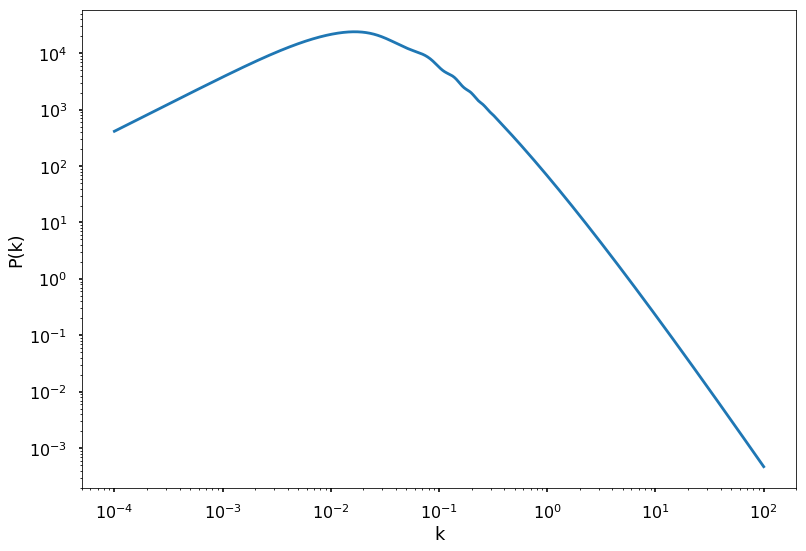

In [312]:
# Generating the power spectrum

k = np.logspace(-4, 2, 1000)
p = EHPower(Planck15, redshift=0.0)(k)
np.savetxt('powerspec.txt', np.array((k, p)).T)

plt.plot(k, p)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')

In the next cell we write the configuration file for FastPM, where we define the resolution of the box ($128^3$ for simplicity) and the size of the box ($20\;h^{-1}\mathrm{Mpc}$). The size of the box is quite small compared to what is usually used in the literature. However, it will allow us to resolve the filaments, and I believe it is better for the visualization.

In [78]:
N=128
boxsize=10.

In [79]:
%%file nbodykit.lua

nc = 128
boxsize = 10.0

time_step = linspace(0.01, 0.15, 10)

output_redshifts= {6.0,7.0,8.0,9.0,10.0,50.}  -- redshifts of output

omega_m = 0.307494
h       = 0.6774

read_powerspectrum= "powerspec.txt"
read_grafic_gaussian= "test.high.ref.amps" 
-- random_seed= 100

pm_nc_factor = 2

np_alloc_factor= 4.0      -- Amount of memory allocated for particle

write_snapshot= "fastpm" 
write_nonlineark= "fastpm" 

-- 1d power spectrum (raw), without shotnoise correction
write_powerspectrum = "powerspec-debug"

Overwriting nbodykit.lua


Next cell is actually runs the simulation. It may take some time (order of minutes for N=128) to complete.

In [80]:
%%bash
export OMP_NUM_THREADS=1
mpirun -n 4 fastpm nbodykit.lua

[ 0000000.0000 ]: This is FastPM, with libfastpm version 1.0.8442714069.
[ 0000000.0048 ]: Configuration {
	boxsize = 10.0,
	compute_potential = false,
	dealiasing_type = "none",
	dh_factor = 1.0,
	enforce_broadband_kmax = 4,
	f_nl_type = "none",
	force_mode = "fastpm",
	h = 0.677400000000000002,
	inverted_ic = false,
	kernel_type = "3_4",
	kmax_primordial_over_knyquist = 0.25,
	nc = 128,
	np_alloc_factor = 4.0,
	omega_m = 0.30749399999999999,
	painter_support = 2,
	painter_type = "cic",
	pm_nc_factor = 2,
	read_powerspectrum = "powerspec.txt",
	remove_cosmic_variance = false,
	set_mode_method = "override",
	shift = false,
	sigma8 = 0,
	write_nonlineark = "fastpm",
	write_powerspectrum = "powerspec-debug",
	write_snapshot = "fastpm",
	za = false,
	aout = {
		0.142857142857142849,
		0.125,
		0.111111111111111105,
		0.100000000000000006,
		0.090909090909090912,
		0.019607843137254902,
	},
	output_redshifts = {
		6.0,
		7.0,
		8.0,
		9.0,
		10.0,
		50.0,
	},
	time_step = {
		0.01,
		0.024

We can check the folder and see whether snapshots were generated.

In [81]:
ls 

fastpm_0.0196/              powerspec-debug_0.2080.txt
fastpm_0.0909/              powerspec-debug_0.2800.txt
fastpm_0.1000/              powerspec-debug_0.3070.txt
fastpm_0.1111/              powerspec-debug_0.3700.txt
fastpm_0.1250/              powerspec-debug_0.4060.txt
fastpm_0.1429/              powerspec-debug_0.4600.txt
fof.py                      powerspec-debug_0.5050.txt
nbodykit.lua                powerspec-debug_0.5500.txt
powerspec-debug_0.0100.txt  powerspec-debug_0.6040.txt
powerspec-debug_0.0240.txt  powerspec-debug_0.6400.txt
powerspec-debug_0.0380.txt  powerspec-debug_0.7030.txt
powerspec-debug_0.0520.txt  powerspec-debug_0.7300.txt
powerspec-debug_0.0660.txt  powerspec-debug_0.8020.txt
powerspec-debug_0.0800.txt  powerspec-debug_0.8200.txt
powerspec-debug_0.0940.txt  powerspec-debug_0.9010.txt
powerspec-debug_0.1000.txt  powerspec-debug_0.9100.txt
powerspec-debug_0.1080.txt  powerspec-debug_1.0000.txt
powerspec-debug_0.1090.txt  powerspec-debug_linear.txt
powerspec-

In [82]:
part = BigFileCatalog('fastpm_0.1250', dataset='1/', header='Header')


In [83]:
q = part.to_mesh(Nmesh=N)
q = q.to_field()

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


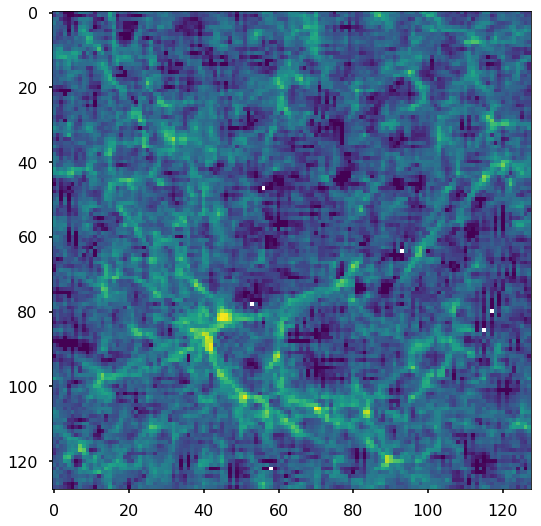

In [84]:
plt.imshow(np.log10(q[0,:,:]),vmin=-1)

The next cell should run the halo finder directly from the notebook, but it does not work for some reason. You have to do it manually in the terminal.

In [321]:
%%bash
python fof.py fastpm_0.1250/ 0.2 fastpm_0.1250/fof

BoxSize [ 10.  10.  10.]
Nmesh [ 128.  128.  128.]
Mass of a particle 40688316.8221
OmegaM 0.3074940000004297


Traceback (most recent call last):
  File "fof.py", line 53, in <module>
    main()
  File "fof.py", line 36, in main
    cat['Density'] = KDDensity(cat).density
  File "/home/kaurov/anaconda3/lib/python3.5/site-packages/nbodykit/algorithms/kdtree.py", line 48, in __init__
    self.run()
  File "/home/kaurov/anaconda3/lib/python3.5/site-packages/nbodykit/algorithms/kdtree.py", line 70, in run
    pos = self._source.compute(self._source['Position'])
  File "/home/kaurov/anaconda3/lib/python3.5/site-packages/nbodykit/base/catalog.py", line 372, in __getitem__
    return ColumnAccessor(memowner, r, is_default=is_default)
  File "/home/kaurov/anaconda3/lib/python3.5/site-packages/nbodykit/base/catalog.py", line 42, in __new__
    daskarray.shape)
TypeError: object() takes no parameters


# Painting the EoR

Now we finally come to the point when we start to plot the ionizing regions.

To recap. At this point we have the following data:
* Initial (linear) density field
* Scalar density field an multiple redshifts
* Halo catalogs

In [674]:
def sph_filter(r, N, mode, f = lambda x, y: x**2+y):
    ''' Constructs spherical filter
    Args:
      r:     parameter
      N:     size of the grid
      mode:
      f:     function, i.e. (f = lambda x, y: x**2+y)
    '''
    x,y,z = np.mgrid[:N,:N,:N]
    x[x>N/2] = N - x[x>N/2]
    y[y>N/2] = N - y[y>N/2]
    z[z>N/2] = N - z[z>N/2]
    r2 = (x**2+y**2+z**2)
    if mode == 'tophat':
        temp = r2<r**2
    elif mode == 'gaussian':
        temp = np.exp(-0.5*(r2/r**2))
    elif mode == 'r^-2':
        temp = 1/(r2+r)
    elif mode == 'custom':
        temp = f(np.sqrt(r2), r)
    return temp / np.sum(temp)

def ft_sph_filter(r, N, mode, f = lambda x, y: x**2+y):
    return np.fft.rfftn(sph_filter(r, N, mode, f))

def smooth(ft_data, r, N, mode, f = lambda x, y: x**2+y):
    return np.fft.irfftn(ft_sph_filter(r, N,mode,f) * ft_data)

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


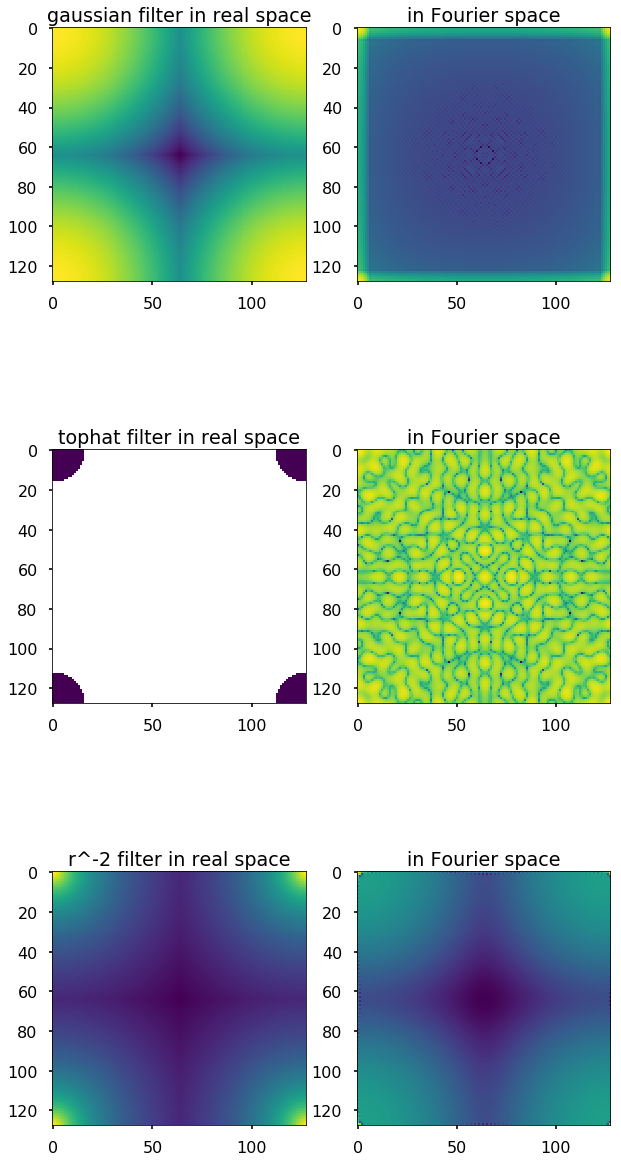

In [675]:
plt.figure(figsize=(10,22))
for i, filt in enumerate(['gaussian', 'tophat', 'r^-2']):
    plt.subplot(3,2,2*i+1)
    plt.imshow(np.log10(sph_filter(16,N,filt))[:,:,0])
    plt.title(filt + ' filter in real space')
    plt.subplot(3,2,2*i+2)
    plt.imshow(np.log10(np.abs(ft_sph_filter(16,N,filt)[:,:,64])))
    plt.title('in Fourier space')
# print(np.abs(ft_sph_filter(50,N,'gaussian')[:,:,64]))

## Simplest model

In the original work FZH04, where the excursion set approach applied to the EoR was introduced, the model consisted of 3 parameters...

In [324]:
part = BigFileCatalog('fastpm_0.0196', dataset='1/', header='Header')
ic = part.to_mesh(Nmesh=N).to_field()
ic = np.array(ic)

In [325]:
f_ic = np.fft.rfftn(ic)

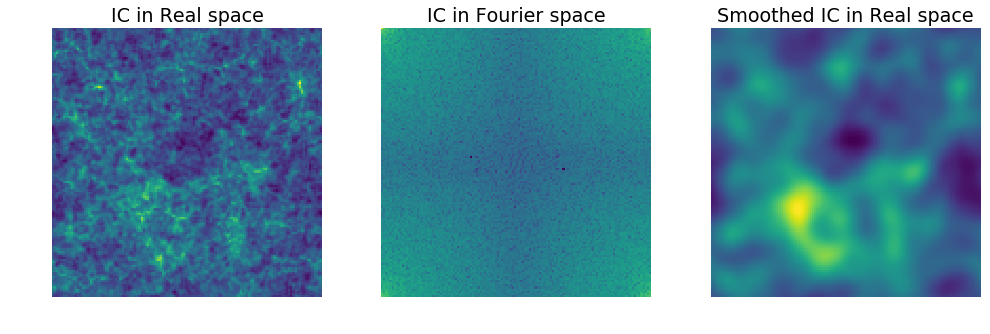

In [326]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.imshow(ic[0,:,:])
plt.axis('off')
plt.title('IC in Real space')
plt.subplot(132)
plt.imshow(np.log10(np.abs(f_ic[:,:,0])))
plt.axis('off')
plt.title('IC in Fourier space')
plt.subplot(133)
plt.imshow(smooth(f_ic, 4, 128, 'gaussian')[0,:,:])
plt.axis('off')
plt.title('Smoothed IC in Real space')

plt.tight_layout()

In [327]:
from scipy.stats import norm
def get_trajectories(field, 
                     sm_scales=np.array([1,2,4,8,16,32,64,128,256], dtype=float), 
                     filter_mode='gaussian', 
                     normalization='None'):
    """Generating 'trajectories' for the 3D field

    Args:
        field (3d float array):  Original neutral fraction field of IGM.
        sm_scales (float array): List of smoothing scales.
        filter_mode     (str):   Coefficient.
        normalization (str):     For each smoothing scale we can normalize the 
                                 resulting smooth field. Options are: 
                                 'None' - do nothing.
                                 'rankorder' - assign to the cell its order
                                 'gaussian' - same as above, but the distribution is

    Returns:
        fHI_mod: Neutral fraction field that includes filaments.

    """
    f_field = np.fft.rfftn(field)
    N = field.shape[0]
    res = np.zeros([N,N,N,len(sm_scales)])
    for i,scale in enumerate(sm_scales):
        res[:,:,:,i] = smooth(f_field, scale, N, mode=filter_mode)
        if normalization == 'rankorder':
            res[:,:,:,i] = rankdata(res[:,:,:,i].reshape([N**3]), method='ordinal').reshape([N,N,N])
            res[:,:,:,i] = res[:,:,:,i]/(N**3-1)
        if normalization == 'gaussian':
            res[:,:,:,i] = rankdata(res[:,:,:,i].reshape([N**3]), method='ordinal').reshape([N,N,N])
            res[:,:,:,i] = res[:,:,:,i]/(N**3-1)
            res[:,:,:,i] = norm.ppf(res[:,:,:,i], loc=0, scale=1)
#             res[:,:,:,i] -= res[:,:,:,i].mean()
#             res[:,:,:,i] /= res[:,:,:,i].std()
    return res

In [328]:
field = get_trajectories(ic, filter_mode='tophat', normalization='gaussian')

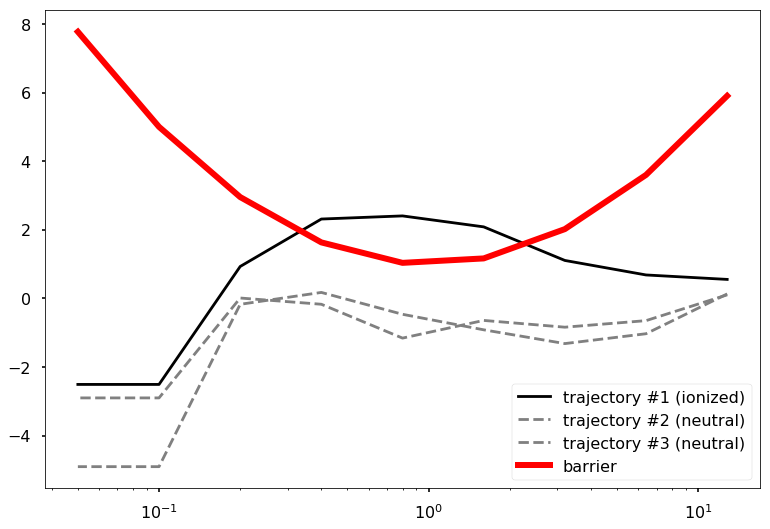

In [330]:
def barrier(s):
    return 4.*(np.log10(s)+0.)**2+1.0

temp_x = N/sm_scales/boxsize
plt.plot(temp_x, field[0,100,40,:], '-', c='k', label='trajectory #1 (ionized)')
plt.plot(temp_x, field[0,0,0,:], '--', c='gray', label='trajectory #2 (neutral)')
plt.plot(temp_x, field[0,30,100,:], '--', c='gray', label='trajectory #3 (neutral)')
plt.plot(temp_x, barrier(temp_x), linewidth=6, c='r', label='barrier')
plt.legend()
plt.xscale('log')

In [331]:
ion = np.zeros([N,N,N])
for i,scale in enumerate(sm_scales):
    ion[field[:,:,:,i] > barrier(N/scale/boxsize)] = 1

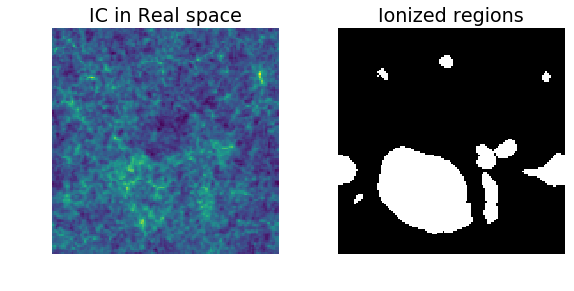

In [332]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(ic[0,:,:])#.sum(2))
plt.axis('off')
plt.title('IC in Real space')
plt.subplot(132)
plt.imshow(ion[0,:,:],cmap='gray')
plt.axis('off')
plt.title('Ionized regions')

plt.tight_layout()

___
#### Comment on the origins of barrier

The shape of the barrier, which we took arbitrary for the purpose of illustration in this notebook, can be calculated using some physical assumptions and parametrized with some physically-motivated variables. In the original paper by [Fulanetto et al. (2004)](https://ui.adsabs.harvard.edu/#abs/2004ApJ...613....1F/abstract) the parametrization is $\zeta$, $\sigma_\mathrm{min}$ and $z$ that correspond to the efficieny of producing ionizing photons, minimum scale/mass of star formation region ($T_\mathrm{vir} < 10^4 K$) and redshift.

There are many extensions of this physical model. I personally wrote a couple of papers on extending this model with [halo bias and LLS](https://ui.adsabs.harvard.edu/#abs/2013ApJ...771...35K/abstract) and [recombination clumping factor](https://ui.adsabs.harvard.edu/#abs/2014ApJ...787..146K/abstract). My personal view to this problem is that ultimately we want to fit the parameters of the semi-analytical models (based on the excusion set formalism, bias expansion, etc) into our best, most  complete, numerical simulation; and then use the semi-analytical model to probe larger volumes and wider parameter spaces. I discuss this approach in [Kaurov (2016)](https://ui.adsabs.harvard.edu/#abs/2016ApJ...831..198K/abstract).


#### DIY

* Implement the shape of the barrier from [Fulanetto et al. (2004)](https://ui.adsabs.harvard.edu/#abs/2004ApJ...613....1F/abstract).

___

## Model with halos

In previous section we used only the ICs. One can rightfully argue that the bubbles should form only around the halos with stars. Therefore, it is logical to use the density of stars (or halos) instead of simly DM density.

Luckly we have the halo catalog. The routines provided with FastPM allows us to quickly find halos using Friends-of-Friends algorithm.

In [333]:
# We load again the snapshot of the DM particles and project the density onto the 3D grid 'q'

part = BigFileCatalog('fastpm_0.1250', dataset='1/', header='Header')
q = part.to_mesh(Nmesh=128)
q = q.to_field()

In [334]:
# Also, we load the catalog of DM halos that we generated in the section 'Preparations'

halos = BigFileCatalog('fastpm_0.1250/fof/0.200/',header='Header')
# ic = part.to_mesh(Nmesh=128).to_field()
# ic = np.array(ic)

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)


Text(0,0.5,'N')

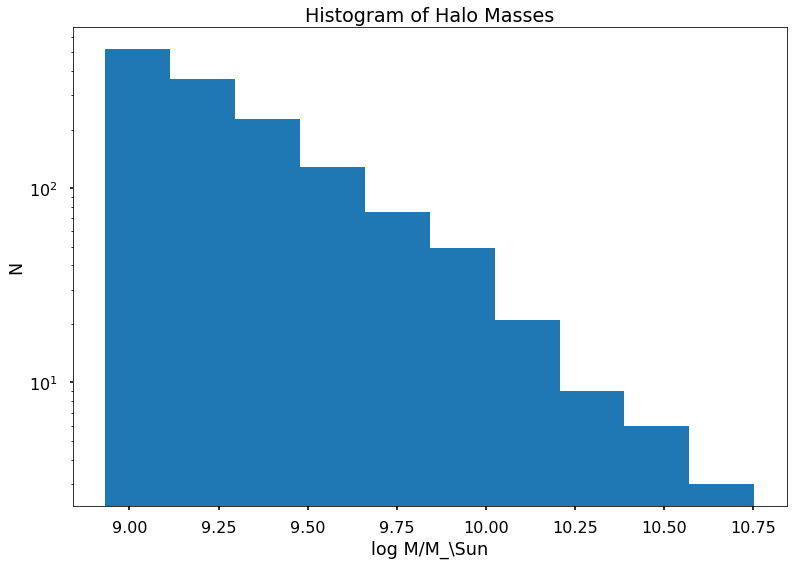

In [335]:
# Here is a plot of the mass fuction

plt.hist(np.log10(halos['Mass'])[1:])
plt.title('Histogram of Halo Masses')
plt.yscale('log')
plt.xlabel('log M/M_\Sun')
plt.ylabel('N')

(0, 128)

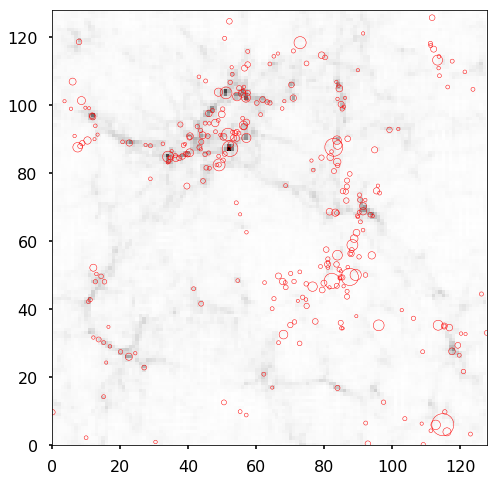

In [336]:
# Next overplot halos on top of the density field in a slice.

M = np.array(halos['Mass'])
pos = np.array(halos['CMPosition'])

# Filter only halos of given mass and located in a slice
filt = (M>10**9.) & (pos[:,0]>0) & (pos[:,0]<2)

plt.figure(figsize=(8,8))
plt.imshow(q[:10,:,:].sum(0), cmap='gray_r')
plt.scatter(pos[filt,2]/ boxsize*N, pos[filt,1] / boxsize*N, s=(M[filt]/1e9)*10., edgecolor='r', facecolor='None')

plt.xlim([0,N])
plt.ylim([0,N])

One can come up with multiple recepies for assigning the number of ionizing photons per halo. Here we assume that it is proportional to the mass, and that halos below some $M_{crit} = 10^{9} M_\odot$ do not form stars.

In [337]:
# we want to take only halos above 10^10 M_\Sun
filt = (M>1e9)

halo_field_m = np.zeros([N,N,N])

for i,(m,x,y,z) in enumerate(zip(M[filt],
                                 (pos[filt,0])/boxsize*N, 
                                 (pos[filt,1])/boxsize*N, 
                                 (pos[filt,2])/boxsize*N)):
    halo_field_m[int(x),int(y),int(z)] += 1.0 * m


# halo_field += q*1e10

In [338]:
# We add the density fild multiplied by a small constant in order to avoid numerical singularities in the future.

halo_field = halo_field_m + q*1e-2

Text(0.5,0,'Mpc/h')

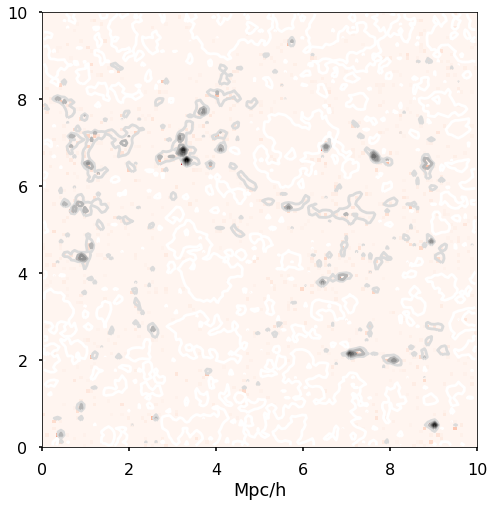

In [339]:
# quick check that halos follow the density field

plt.figure(figsize=(8,8))
plt.imshow(halo_field[:,:,:].sum(0),extent=(0,boxsize,0,boxsize), cmap='Reds', origin='lower')
plt.contour((q[:,:,:].sum(0)),extent=(0,boxsize,0,boxsize), cmap='gray_r', origin='lower')

plt.xlim([0,boxsize])
plt.ylim([0,boxsize])

plt.xlabel('Mpc/h')

In [340]:
field = get_trajectories(halo_field, filter_mode='gaussian', normalization='rankorder')

(0, 1.5)

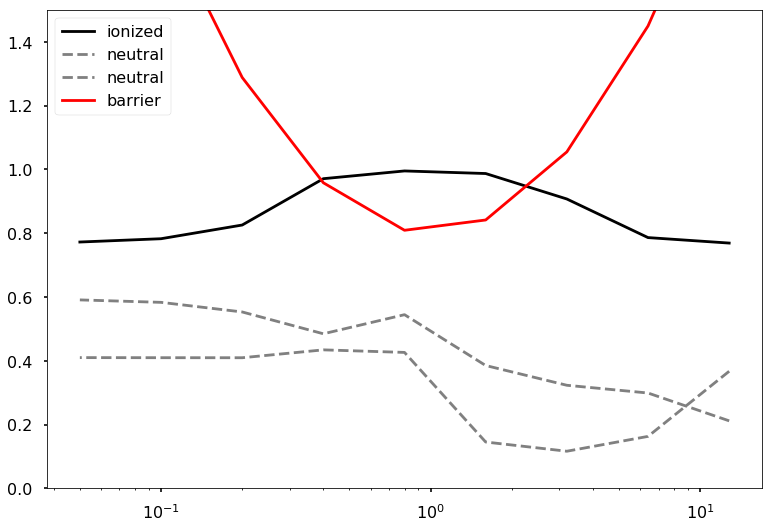

In [341]:
def barrier(s):
#     return s*0 + 0.9
    return 1*(np.log10(s)+0.0)**2+0.8

temp_x = N/sm_scales/boxsize
plt.plot(temp_x, field[0,100,40,:], '-k', label='ionized')
plt.plot(temp_x, field[0,0,0,:], '--', c='gray', label='neutral')
plt.plot(temp_x, field[0,30,100,:], '--', c='gray', label='neutral')
plt.plot(temp_x, barrier(temp_x), 'r', label='barrier')

plt.legend()
plt.xscale('log')
plt.ylim([0,1.5])

In [342]:
ion = np.zeros([N,N,N])
for i,scale in enumerate(sm_scales):
    ion[field[:,:,:,i] > barrier(N/scale/boxsize)] = 1

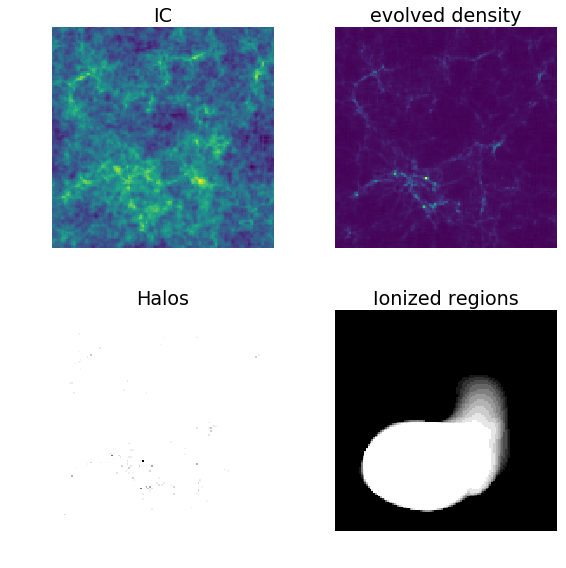

In [343]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(ic[:10,:,:].sum(0))
plt.axis('off')
plt.title('IC')
plt.subplot(222)
plt.imshow(q[:10,:,:].sum(0))
plt.axis('off')
plt.title('evolved density')
plt.subplot(223)
plt.imshow(halo_field[:10,:,:].sum(0),cmap='gray_r')
plt.axis('off')
plt.title('Halos')
plt.subplot(224)
plt.imshow(ion[:10,:,:].sum(0),cmap='gray')
plt.axis('off')
plt.title('Ionized regions')

plt.tight_layout()

### Reionization field

Now we would like to simulate not only the state of the reionization at a single redshift, but full history. Again, we will do it completely in a model agnostic way. We do not adopt any phtsical model, we use a moving barrier insted.

In [344]:
def barrier(s, h):
#     return s*0 + 0.9
    return 4*(np.log10(s)+0.0)**2+h

def r_barrier(s, v):
    return v-4*(np.log10(s)+0.0)**2

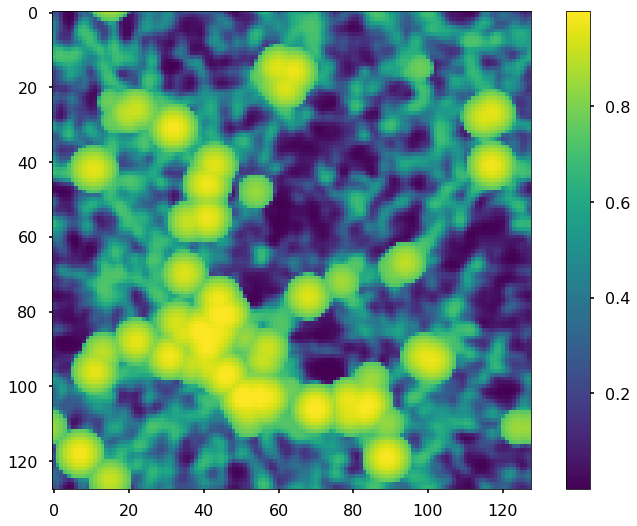

In [345]:
plt.imshow(field[0,:,:,0])
plt.colorbar()

We look for the largest h, for with each cell is ionized. Later we will rank order the cells according to h and will derive redshift from it.

In [346]:
h_field = np.zeros([N,N,N,len(sm_scales)])
for i,scale in enumerate(sm_scales):
    h_field[:, :, :, i] = r_barrier(N/scale/boxsize, field[:,:,:,i])

h_field = h_field.max(3)
print(h_field.shape)
    


(128, 128, 128)


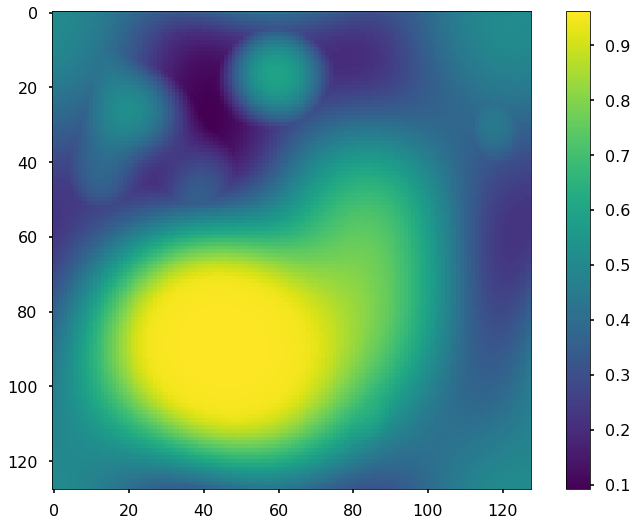

In [347]:
plt.imshow(h_field[0,:,:])
plt.colorbar()

In [348]:
h_field.min()

-0.03756572564750106

Now we need to come up with some reionization history.

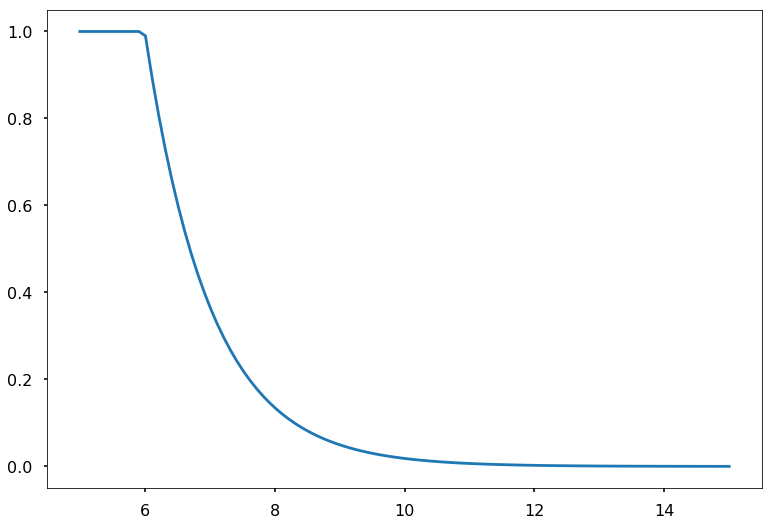

In [349]:
def reion_history(z):
    res = np.exp((6-z)/1.)
    res[z<6] = 1.0
#     res = np.arctan((8.-z)*5.)/np.pi+0.5
    return res

z_list = np.linspace(15,5,100)
plt.plot(z_list, reion_history(z_list))

# interpolation

percs = np.linspace(0,1,1024)
percs_z = np.interp(percs, reion_history(z_list), z_list)

# plt.plot(percs, percs_z)

In [350]:
z_field = h_field.copy()*0.0
f_field = h_field.copy()*0.0
percs_h = np.percentile(-h_field.flatten(), percs*100.)
for i in range(len(percs)-1):
    temp = (-h_field>=percs_h[i]) & (-h_field<=percs_h[i+1])
    print(np.sum(temp))
    z_field[temp] = (percs_z[i] + percs_z[i+1])/2.
    f_field[temp] = 1.*i/len(percs)

2051
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050
2050


Text(0,0.5,'Number of cells ionized at given redhsift')

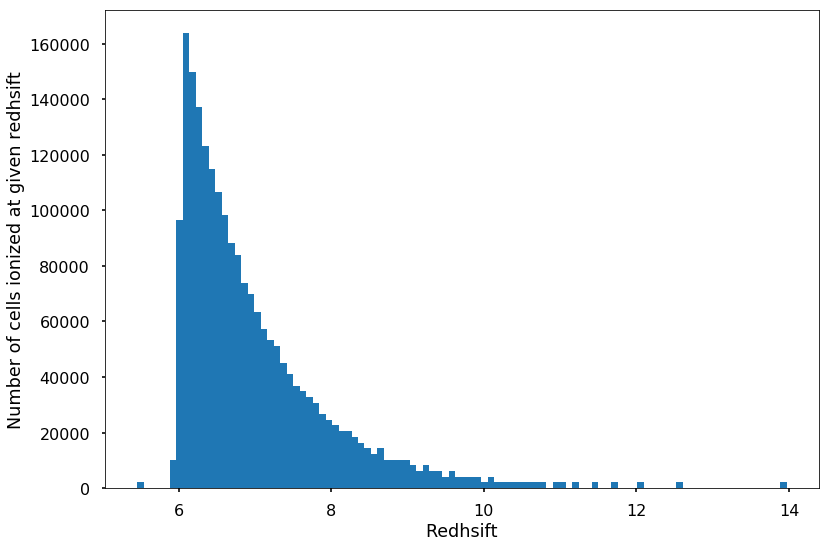

In [351]:
temp = plt.hist(z_field.flatten(),100)
plt.xlabel('Redhsift')
plt.ylabel('Number of cells ionized at given redhsift')

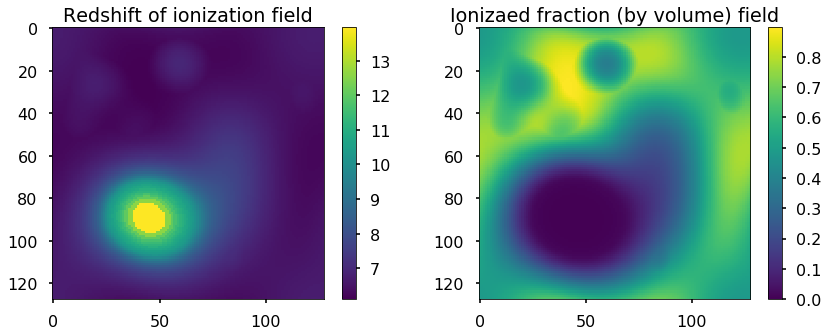

In [352]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(z_field[0,:,:])
plt.title('Redshift of ionization field')
plt.colorbar()
plt.subplot(122)
plt.imshow(f_field[0,:,:])
plt.title('Ionizaed fraction (by volume) field')
plt.colorbar()

___
#### DIY

* We used only one redshift snapshot for defining halos. One can easily improve the code by using appropriate halo catalogs at each redshift.
* Since we have multiple fields -- halo density, DM density -- one can come up with a better estimator.
* One can try to improve the barrier approach by using more sophisticated function. However, one should remember that one of the benefits of a moving barrier is its smoothemess, i.e. the regions become ionized subsecuently from halos outwards.
* We defined inonization history by setting the ionization fraction of the **volume**. However, the fraction weighted by **mass** is more physical, since the global optical depth, $\tau$, is proportional to the total number of free electrons. One can easily modify the rank ordering function and fix this issue.
___

# Breaking spherical symmetry

The text above explains the use of 
Excursion set formalism intrisincally assumes spherical symmetry.

In the following sections we introduce the following corrections:
* Contribution from filaments. The importance of them is discussed in Kaurov&Gnedin (2016) and their contribution to the 21cm PS can be of order 50%. In Kaurov (2016) a simple approach to fix it is proposed.
* "Butterfly" shape of bubbles around individual halos. They are caused because the ionization fronts propagate slower inside the filaments. This effect can be mimicked by adopting the Largrangian space.
* Stochastic component due to the inhomogeneous escape fraction and non-constant star formation in the galaxies.

## Filaments

Neutral fraction in the filaments is proportinal to its local density. This model of late reionization is proposed by Miralde-Escude (...). It is also applicable to the interiors of the ionized bubbles during the reionization. The way it is implemented further assumes uniform ionizing background in each bubble. This assumption is not true (see for instance Kaurov&Gnedin 2015), but we will keep it for simplicity.



In [138]:
fHI = 1.0*(f_field>0.5)

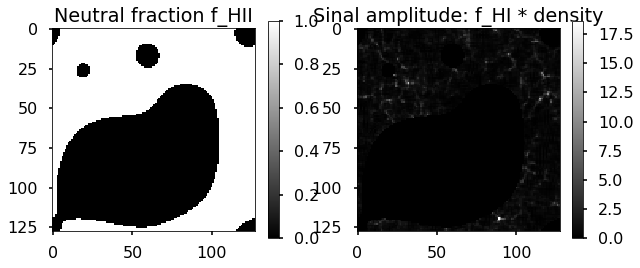

In [139]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.title('Neutral fraction f_HII')
plt.imshow(fHI[0,:,:], cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.title('Sinal amplitude: f_HI * density')
plt.imshow((fHI*q)[0,:,:], cmap='gray')
plt.colorbar()

In [153]:
def pk(data, boxsize, k_list_phys):
    '''Power spectrum of 3D box
    
    Args:
        data (3d float array):     3D field.
        boxsize (float):           Physical size of the box in Mpc/h.
        k_list_phys (float array): Bins in k space.

    Returns:
        P(k): The power spectrum binned by k_list_phys.    
    '''
    # Detect number of cells
    N = data.shape[0]
    # Convert k_list_phys to k_list -- k-space of the box
    k_list = k_list_phys*boxsize/N
    # Real FFT of the input 3D field
    data=np.fft.rfftn(data)
    # Evaluating the k in each cell in the k-space
    kx, ky, kz = np.mgrid[:N, :N, :(N/2+1)]
    kx[kx > N/2-1] = kx[kx > N/2-1]-N
    ky[ky > N/2-1] = ky[ky > N/2-1]-N
    kz[kz > N/2-1] = kz[kz > N/2-1]-N
    k=2.0*np.pi*np.sqrt(kx**2+ky**2+kz**2)/N
    # We use np.histogram to quickly evaluate average value in each bin
    h1, dump = np.histogram(k.flat,weights=np.abs(data.flat)**2,bins=k_list)
    h2, dump = np.histogram(k.flat,bins=k_list)
    h2[h2==0] = 1.0
    res = h1/h2
    # Normalization
    res *= boxsize**3/N**6
    return res


In [154]:
k_list=np.arange(0.0,N,4)/N
k_list_phys=k_list*N/boxsize
print(k_list, k_list_phys)

PS_HI = pk((fHI*q), boxsize, k_list_phys)

[0.      0.03125 0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25
 0.28125 0.3125  0.34375 0.375   0.40625 0.4375  0.46875 0.5     0.53125
 0.5625  0.59375 0.625   0.65625 0.6875  0.71875 0.75    0.78125 0.8125
 0.84375 0.875   0.90625 0.9375  0.96875] [ 0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8  5.2
  5.6  6.   6.4  6.8  7.2  7.6  8.   8.4  8.8  9.2  9.6 10.  10.4 10.8
 11.2 11.6 12.  12.4]


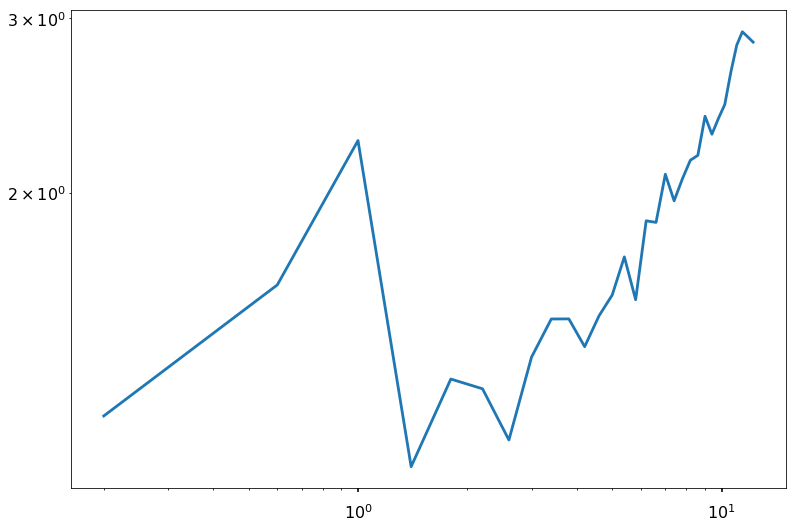

In [155]:
k_list_phys_centers = (k_list_phys[1:] + k_list_phys[:-1])/2.0
plt.plot(k_list_phys_centers, PS_HI*k_list_phys_centers**3)
plt.xscale('log')
plt.yscale('log')

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/pmesh/pm.py:115: RuntimeWarning: divide by zero encountered in power
  r[...] = self[...] ** other


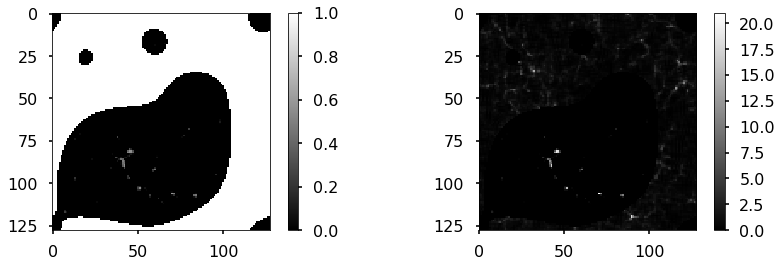

In [156]:
plt.figure(figsize=(14,4))


def add_filaments(fHI_IGM, density, n_c):
    """Adding filaments to the simulation

    Under the assumption that the filaments are resolved and optically
    thin to the ionizing background, we can apply a simple rule for
    estimating the neutral fraction. Naively you can think :

    Args:
        fHI_IGM (3d float array): Original neutral fraction field of IGM.
        density (3d float array): Density.
        n_c     (float):          Coefficient.

    Returns:
        fHI_mod: Neutral fraction field that includes filaments.

    """
    fHI_mod = fHI_IGM.copy()
    fHI_mod += 1.0-n_c*q**-0.5
    fHI_mod[fHI_IGM==1]=1
    fHI_mod[fHI_mod>1] = 1
    fHI_mod[fHI_mod<0] = 0
    return fHI_mod

fHI_mod = add_filaments(fHI, q, n_c=2.5)
plt.subplot(121)
plt.imshow(fHI_mod[0,:,:], cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.imshow((fHI_mod*q)[0,:,:], cmap='gray')
plt.colorbar()

In [149]:
PS_HI_mod = pk((fHI_mod*q), boxsize, k_list_phys)

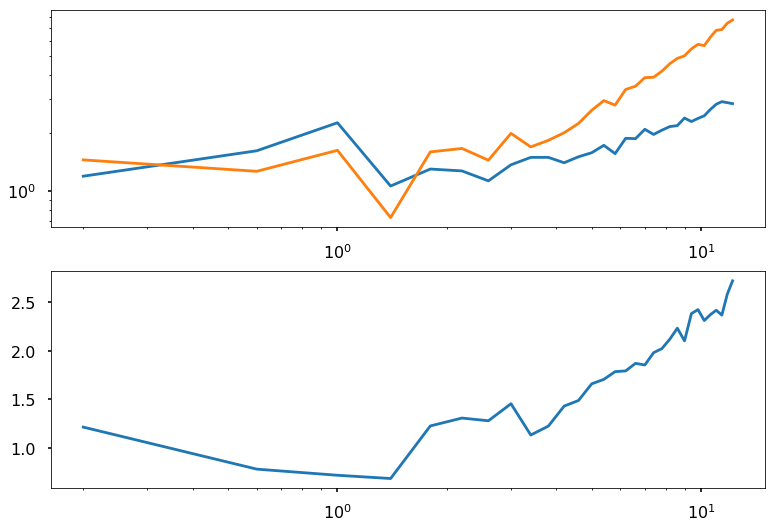

In [150]:
plt.subplot(211)
plt.plot(k_list_phys_centers, PS_HI*k_list_phys_centers**3)
plt.plot(k_list_phys_centers, PS_HI_mod*k_list_phys_centers**3)
plt.xscale('log')
plt.yscale('log')

plt.subplot(212)
plt.plot(k_list_phys_centers, PS_HI_mod/PS_HI)
plt.xscale('log')
# plt.yscale('log')

DIY:

* Semi-neutral filaments are the function of the UV background, which is inversly proportional to the distance to the halos. Using the same filtering technique with $1/r^2$ one can improve the estimate. 
* Halos can (and should) be treated differently. The neutral gas in them does not follow the rule used for the filaments.


## Filaments in the proximity to the halos

The simulation of ionizing fronts near the individual galaxies often show the "butterfly" shape of the ionizing fronts. The reason for that is simple. Any galaxy has the filaments "connected" to it and this whole system is located in Zeldovich "pancake". Therefore, even if the ionizing radiation escapes spherically symmetrically from the galaxy, the ionization front propagates slower in denser regions, and consequently the shape of the front becomes complicated.

In [227]:
part = BigFileCatalog('fastpm_0.1429', dataset='1/', header='Header')
pos = part['Position'][:,:]

In [228]:
values = f_field.flatten()

(10.0, 0)

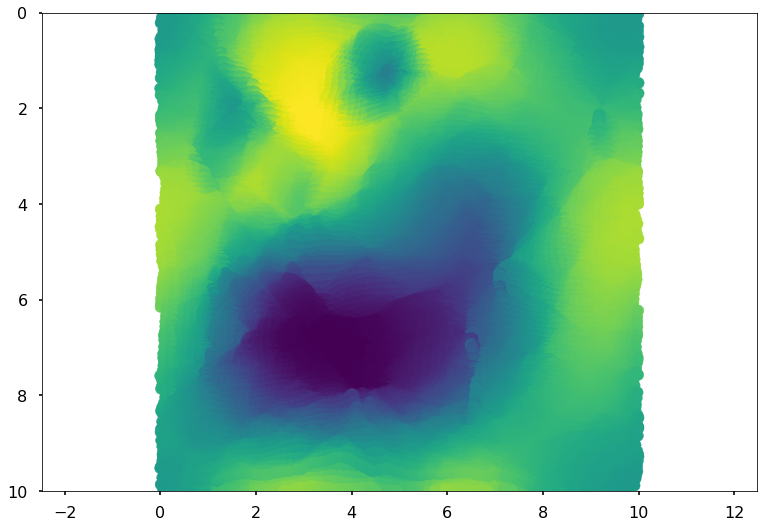

In [229]:
plt.scatter(pos[:N**2,2], pos[:N**2,1], c=values[:N**2])
plt.axis('equal')
plt.xlim([0,boxsize])
plt.ylim([boxsize,0])

In [230]:
grid_0, grid_1, grid_2 = np.mgrid[0:N, 0:N, 0:N]

In [231]:
from scipy.interpolate import griddata
f_field_distorted = griddata(pos/boxsize*N, 
                             values, 
                             (grid_0, grid_1, grid_2), 
                             method='nearest')

In [232]:
f_field_distorted_ranked = rankdata(f_field_distorted.flat).reshape([N,N,N]) / N**3

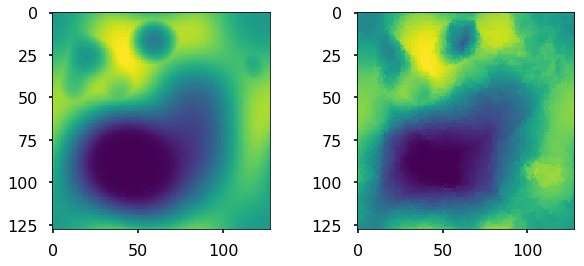

In [233]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.imshow(f_field[0,:,:])

plt.subplot(122)
plt.imshow(f_field_distorted_ranked[0,:,:])


We need to rank order the field again in order to have the same ionization history (by volume).

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/pmesh/pm.py:115: RuntimeWarning: divide by zero encountered in power
  r[...] = self[...] ** other


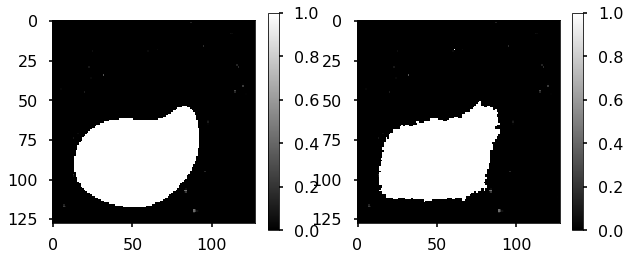

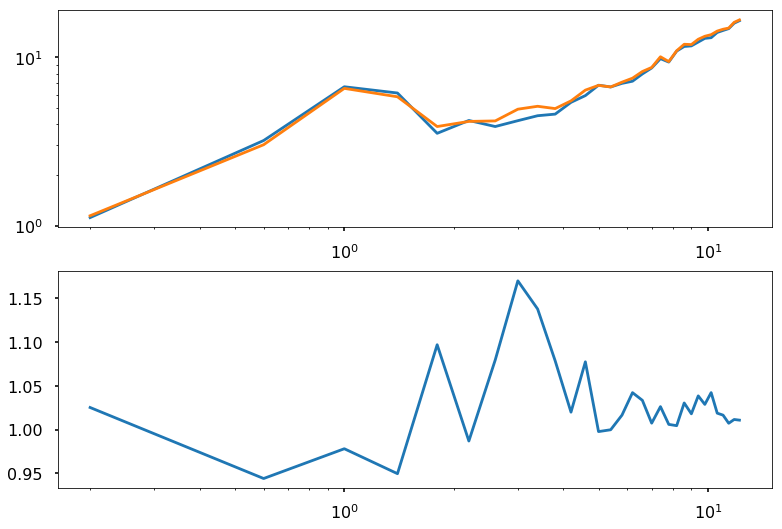

In [372]:
plt.figure(figsize=(10,4))

f_HII = 0.25
n_c = 2.5

ion7 = 1.0*(f_field<f_HII)
ion7_mod = ion7.copy()

ion7_mod += 1.0-n_c*q**-0.5
ion7_mod[ion7==1]=1
ion7_mod[ion7_mod>1] = 1
ion7_mod[ion7_mod<0] = 0

ion7_distorted = 1.0*(f_field_distorted_ranked<f_HII)
ion7_mod_distorted = ion7_distorted.copy()

ion7_mod_distorted += 1.0-n_c*q**-0.5
ion7_mod_distorted[ion7_distorted==1]=1
ion7_mod_distorted[ion7_mod_distorted>1] = 1
ion7_mod_distorted[ion7_mod_distorted<0] = 0


plt.figure(1)
plt.subplot(121)
plt.imshow(ion7_mod[0,:,:], cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.imshow(ion7_mod_distorted[0,:,:], cmap='gray')
plt.colorbar()

PS_HI_mod = pk((ion7_mod*q), boxsize, k_list_phys)
PS_HI_mod_distorted = pk((ion7_mod_distorted*q), boxsize, k_list_phys)

plt.figure(2)
plt.subplot(211)
plt.plot(k_list_phys_centers, PS_HI_mod*k_list_phys_centers**3)
plt.plot(k_list_phys_centers, PS_HI_mod_distorted*k_list_phys_centers**3)
plt.xscale('log')
plt.yscale('log')

plt.subplot(212)
plt.plot(k_list_phys_centers, PS_HI_mod_distorted / PS_HI_mod)
plt.xscale('log')
# plt.yscale('log')

In [196]:

f_list  = np.linspace(0,1,32)
res = np.zeros([len(f_list), len(k_list_phys_centers)])

for i in range(len(f_list)):
    f_HII=f_list[i]
    n_c = 0.5
    # 
    ion7 = 1.0*(f_field<f_HII)
    ion7_mod = ion7.copy()
    ion7_mod += 1.0-n_c*q**-0.5
    ion7_mod[ion7==1]=1
    ion7_mod[ion7_mod>1] = 1
    ion7_mod[ion7_mod<0] = 0
    # 
    ion7_distorted = 1.0*(f_field_distorted_ranked<f_HII)
    ion7_mod_distorted = ion7_distorted.copy()
    ion7_mod_distorted += 1.0-n_c*q**-0.5
    ion7_mod_distorted[ion7_distorted==1]=1
    ion7_mod_distorted[ion7_mod_distorted>1] = 1
    ion7_mod_distorted[ion7_mod_distorted<0] = 0
    # 
    PS_HI_mod = pk((ion7_mod*q), boxsize, k_list_phys)
    PS_HI_mod_distorted = pk((ion7_mod_distorted*q), boxsize, k_list_phys)
    res[i, :] = PS_HI_mod_distorted / PS_HI_mod

# plt.imshow(res, vmin=0.5, vmax=2.)

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/pmesh/pm.py:115: RuntimeWarning: divide by zero encountered in power
  r[...] = self[...] ** other


In [197]:
# def get_pk_field(f_field, f_list, k_list_phys):

k_list_phys_centers


array([ 0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,
        4.6,  5. ,  5.4,  5.8,  6.2,  6.6,  7. ,  7.4,  7.8,  8.2,  8.6,
        9. ,  9.4,  9.8, 10.2, 10.6, 11. , 11.4, 11.8, 12.2])

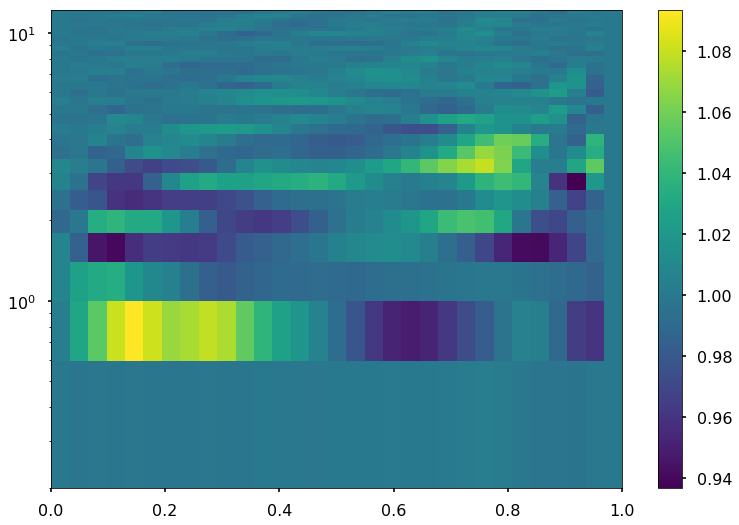

In [198]:
plt.pcolor(1-f_list, k_list_phys_centers, res.T)
# plt.contour(1-f_list, k_list_phys_centers, res.T, levels=[0, 1])
plt.yscale('log')
plt.colorbar()

## Stochasticity

Everything that we did so far is determenistic. All inhomoneities are derived from the fields that are seeded in the ICs. In other words, for one IC field and a given set of parameters we got only one solution. However, it is not the case, since we do not resolve everything. In [Kaurov (2017)](https://ui.adsabs.harvard.edu/#abs/2017arXiv170904353K/abstract) I have shown that the effect of pertrubations on small scales propagating to large scales through ionizing radiation is not negligible. 

### Toy model

Let's assume a homogeneous box with an isolated galaxy in the center. The usual excursion set formalism predicts spherical bubble growing around it. Let's skip the step of applying the excursion set model and manually create the field.

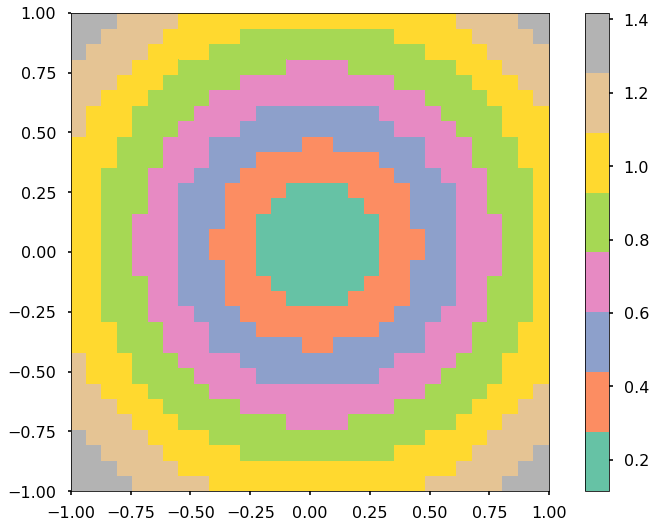

In [855]:
Nt = 32
x, y, z = np.mgrid[-1:1:32j, -1:1:32j, -1:1:32j]
# print(len(x))
r2 = (x**2+y**2+z**2+0.01)
h_field_test = r2**.5
# h_field_test = rankdata(h_field_test.flat).reshape(h_field_test.shape)/Nt**3
plt.pcolor(x[:, 16, :], z[:, 16, :], h_field_test[:,16,:],cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')
plt.colorbar()

As expected, we see spherical contours of ionization front. However, we know that the galaxy emits photons inhomogeneously. The escape fraction of ionizing photons is not spherically symmetric.

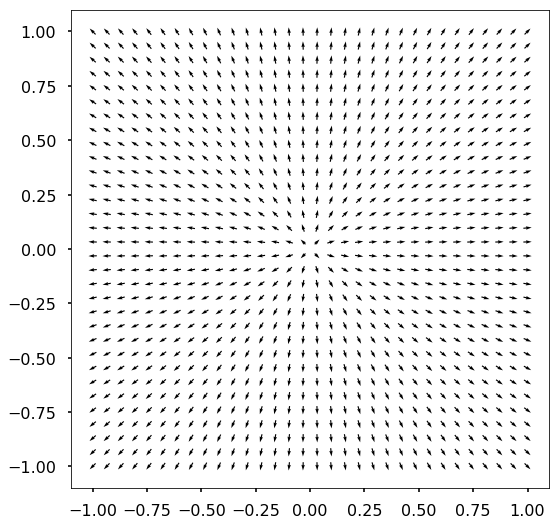

In [856]:
grad0, grad1, grad2 = np.gradient(h_field_test)
norm = np.sqrt(grad0**2+grad1**2+grad2**2)
norm[norm==0] = 1e10
grad0 *= 1/norm
grad1 *= 1/norm
grad2 *= 1/norm

Q = plt.quiver(x[:, :, 0], y[:, :, 0], grad0[:, :, 16], grad1[:, :, 16],
               pivot='mid', units='inches')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

(32, 32, 32)


Text(0.5,0,'x-axis')

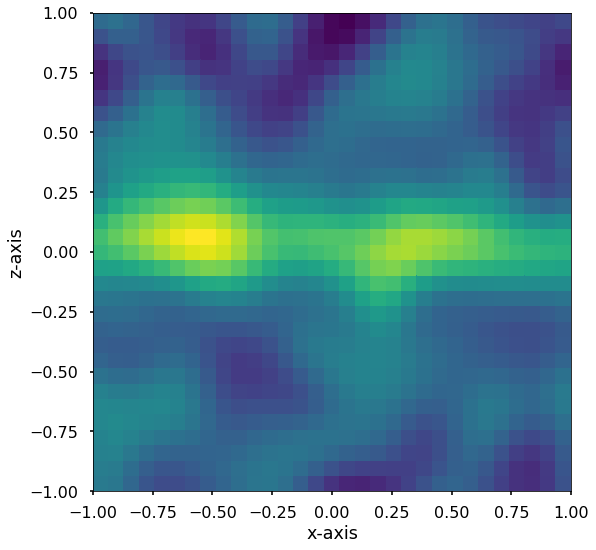

In [964]:
np.random.seed(3140)

deflection_potential = np.random.normal(0,1,size=[Nt, Nt, Nt])
deflection_potential += 6e-4/(z)**2
deflection_potential = np.fft.rfftn(deflection_potential)
# deflection_potential *= np.fft.rfftn((r2+0.01)**-3)
deflection_potential = smooth(deflection_potential, 1.8, Nt, 'gaussian')
print(deflection_potential.shape)
deflection_potential -= deflection_potential.mean()
deflection_potential /= deflection_potential.std()

plt.pcolor(x[:, 16, :], z[:, 16, :], deflection_potential[:,16,:])
plt.axis('equal')
plt.gca().set_adjustable('box-forced')
plt.ylabel('z-axis')
plt.xlabel('x-axis')



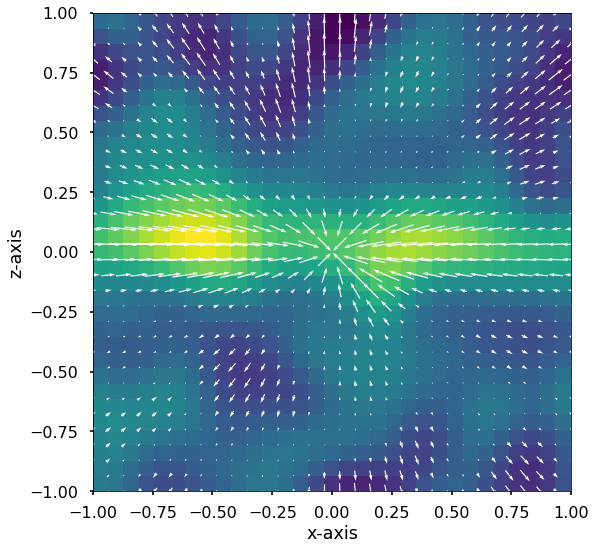

In [965]:
grad0x = - grad0 * deflection_potential
grad1x = - grad1 * deflection_potential
grad2x = - grad2 * deflection_potential


plt.pcolor(x[:, 16, :], z[:, 16, :], deflection_potential[:,16,:])
plt.ylabel('z-axis')
plt.xlabel('x-axis')
Q = plt.quiver(x[:, 16, :], z[:, 16, :], grad0x[:, 16, :], grad2x[:, 16, :],
               pivot='mid', units='inches', color='w')

plt.axis('equal')
plt.gca().set_adjustable('box-forced')

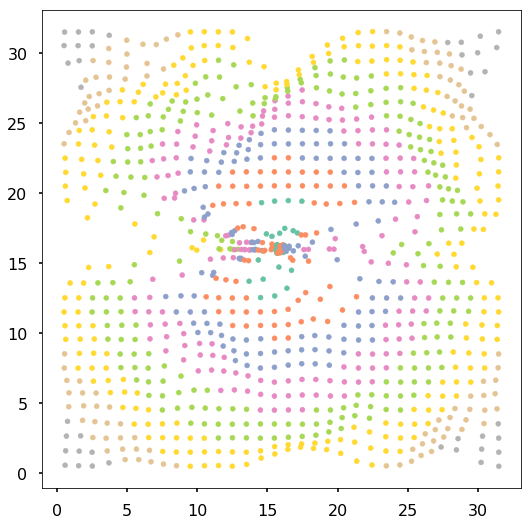

In [966]:
grid_0, grid_1, grid_2 = 0.5 + np.mgrid[0:Nt, 0:Nt, 0:Nt]

# grad_0 = grad0x[np.floor(grid_0_shifted).astype(int), 
#                 np.floor(grid_1_shifted).astype(int),
#                 np.floor(grid_2_shifted).astype(int)].copy()
# grad_1 = grad1x[np.floor(grid_0_shifted).astype(int), 
#                 np.floor(grid_1_shifted).astype(int),
#                 np.floor(grid_2_shifted).astype(int)].copy()
# grad_2 = grad2x[np.floor(grid_0_shifted).astype(int), 
#                 np.floor(grid_1_shifted).astype(int),
#                 np.floor(grid_2_shifted).astype(int)].copy()
dt = .1

grid_0_shifted = grid_0.copy()
grid_1_shifted = grid_1.copy()
grid_2_shifted = grid_2.copy()

for i in range(10):
#     print(i)
    grad_0 = grad0x[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    grad_1 = grad1x[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    grad_2 = grad2x[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    
    norm = deflection_potential[np.floor(grid_0_shifted).astype(int), 
                np.floor(grid_1_shifted).astype(int),
                np.floor(grid_2_shifted).astype(int)]
    
#     print(grad_0)
    grid_0_shifted = grid_0_shifted + grad_0*dt*norm
    grid_1_shifted = grid_1_shifted + grad_1*dt*norm
    grid_2_shifted = grid_2_shifted + grad_2*dt*norm
    
    grid_0_shifted = np.mod(grid_0_shifted, Nt)
    grid_1_shifted = np.mod(grid_1_shifted, Nt)
    grid_2_shifted = np.mod(grid_2_shifted, Nt)
#     print(grid_2_shifted)

# for i in range(30):
#     grid_0_shifted += grad0*dt
#     grid_1_shifted += grad1*dt
#     grid_2_shifted += grad2*dt
    
values = h_field_test

plt.scatter(grid_0_shifted[:,16,:], grid_2_shifted[:,16,:], c=values[:,16,:], s=25.0, cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

In [967]:

values = h_field_test.flatten()
pos = np.array([grid_0_shifted.flatten(), grid_1_shifted.flatten(), grid_2_shifted.flatten()]).T

In [968]:
from scipy.interpolate import griddata
h_field_test_distorted = griddata(pos, values, (grid_0, grid_1, grid_2), method='nearest', fill_value=np.nan)
# h_field_test_distorted = rankdata(f_field_test_distorted.flat).reshape([Nt,Nt,Nt])/Nt**3

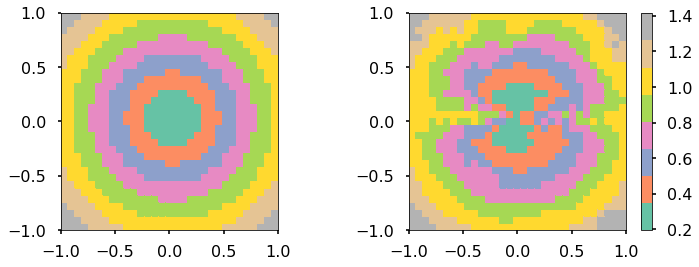

In [969]:
plt.figure(figsize=(12,4))

ax = plt.subplot(121)
plt.pcolor(x[:, 16, :], z[:, 16, :], h_field_test[:,16,:],cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

plt.subplot(122, sharex=ax,sharey=ax)
plt.pcolor(x[:, 16, :], z[:, 16, :], h_field_test_distorted[:,16,:],cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

plt.colorbar()



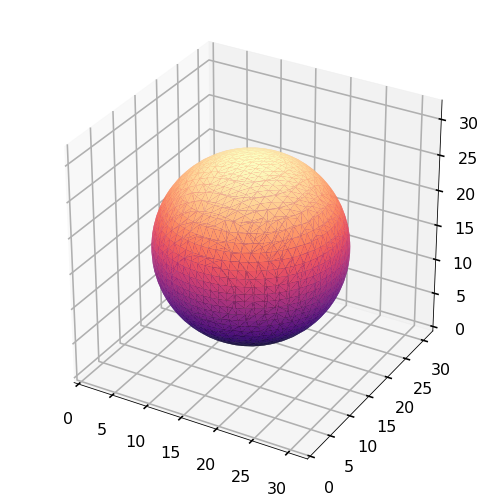

In [970]:
verts, faces = measure.marching_cubes_classic(h_field_test, 0.8, spacing=(1, 1, 1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='magma', lw=1)

ax.set_aspect('equal', 'box')
ax.get_xaxis().set_visible(False)
ax.set_xlim([0,Nt])
ax.set_ylim([0,Nt])
ax.set_zlim([0,Nt])
plt.show()


In [ ]:
verts, faces = measure.marching_cubes_classic(h_field_test_distorted, 0.5, spacing=(1, 1, 1))

def animate(i):
    ax.view_init(elev=(i-6.)*4., azim=45)
    return fig,

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal', 'box')
# ax.get_xaxis().set_visible(False)
ax.set_xlim([0,Nt])
ax.set_ylim([0,Nt])
ax.set_zlim([0,Nt])
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                    cmap='magma', lw=2, shade=True)

ani = matplotlib.animation.FuncAnimation(fig, animate,
                               frames=12, interval=200, blit=True)

HTML(ani.to_jshtml(default_mode='reflect'))

#### Pros and Cons

### Full example

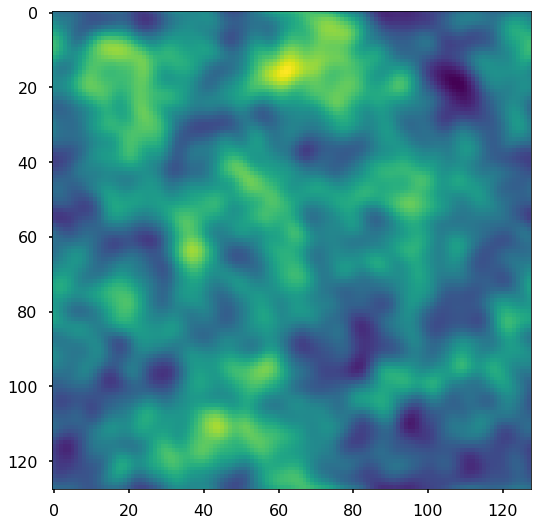

In [852]:
deflection_potential = np.fft.rfftn(q / 1e100 + np.random.normal(0,1,size=[N,N,N]))

x,y,z = np.mgrid[:N,:N,:N]
x[x>N/2] = N - x[x>N/2]
y[y>N/2] = N - y[y>N/2]
z[z>N/2] = N - z[z>N/2]
r2 = (x**2+y**2+z**2)

deflection_potential *= np.fft.rfftn((r2+1)**-1.)
# deflection_potential = np.fft.irfftn(deflection_potential)

deflection_potential = smooth(deflection_potential, 2, N,'gaussian')

deflection_potential -= deflection_potential.mean()
deflection_potential /= deflection_potential.std()

plt.imshow(deflection_potential[0,:,:])

In [300]:
# temp = np.zeros([N, N, N])

# temp[halo_field_m>0] = deflection_potential[halo_field_m>0]

In [301]:
grad0, grad1, grad2 = np.gradient(f_field)
norm = np.sqrt(grad0**2+grad1**2+grad2**2)
norm[norm==0] = 1e10
grad0 *= deflection_potential/norm
grad1 *= deflection_potential/norm
grad2 *= deflection_potential/norm


In [302]:
# np.sqrt(grad0**2+grad1**2+grad2**2)
np.sum(norm==np.nan)

0

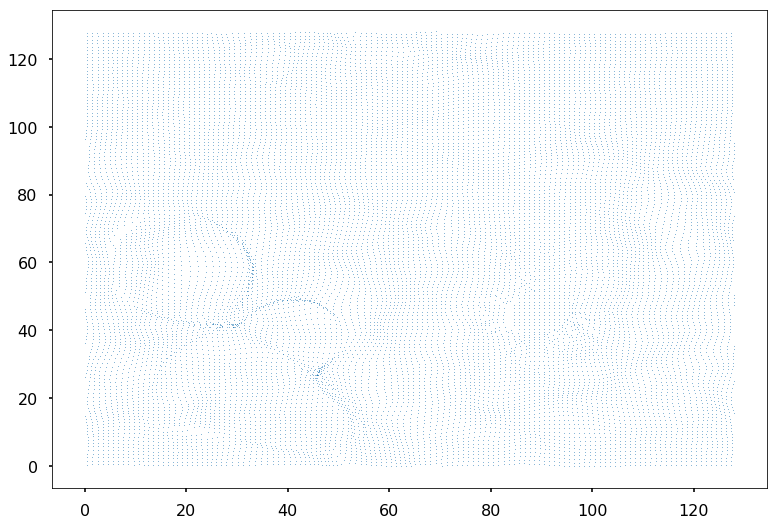

In [354]:
grid_0, grid_1, grid_2 = 0.5 + np.mgrid[0:N, 0:N, 0:N]

dt = .1

grid_0_shifted = grid_0.copy()
grid_1_shifted = grid_1.copy()
grid_2_shifted = grid_2.copy()

for i in range(10):
#     print(i)
    grad_0 = -grad0[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    grad_1 = -grad1[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    grad_2 = -grad2[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    
#     print(grad_0)
    grid_0_shifted = grid_0_shifted + grad_0*dt
    grid_1_shifted = grid_1_shifted + grad_1*dt
    grid_2_shifted = grid_2_shifted + grad_2*dt
    
    grid_0_shifted = np.mod(grid_0_shifted, N)
    grid_1_shifted = np.mod(grid_1_shifted, N)
    grid_2_shifted = np.mod(grid_2_shifted, N)
#     print(grid_2_shifted)

# for i in range(30):
#     grid_0_shifted += grad0*dt
#     grid_1_shifted += grad1*dt
#     grid_2_shifted += grad2*dt
    


plt.scatter(grid_1_shifted[0,:,:], grid_2_shifted[0,:,:],s=0.1)

In [304]:
values = h_field.flatten()
pos = np.array([grid_0_shifted.flatten(), grid_1_shifted.flatten(), grid_2_shifted.flatten()]).T

In [305]:
from scipy.interpolate import griddata
h_field_distorted = griddata(pos, values, (grid_0, grid_1, grid_2), method='nearest')

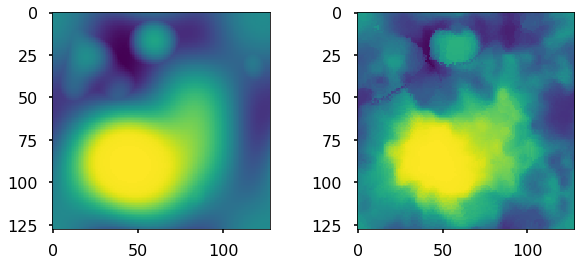

In [306]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.imshow(h_field[0,:,:])

plt.subplot(122)
plt.imshow(h_field_distorted[0,:,:])


In [307]:
z_field_distorted = h_field_distorted.copy()*0.0
percs_h = np.percentile(-h_field_distorted.flatten(), percs*100.)
for i in range(len(percs)-1):
    temp = (-h_field_distorted>=percs_h[i]) & (-h_field_distorted<=percs_h[i+1])
    z_field_distorted[temp] = (percs_z[i] + percs_z[i+1])/2.


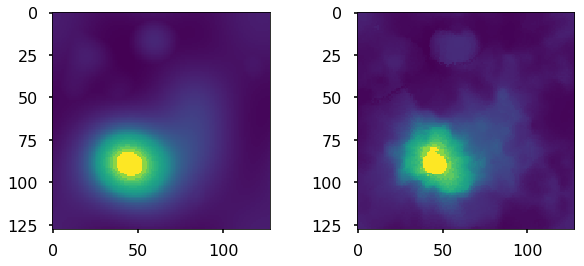

In [308]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.imshow(z_field[0,:,:])

plt.subplot(122)
plt.imshow(z_field_distorted[0,:,:])


/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/pmesh/pm.py:115: RuntimeWarning: divide by zero encountered in power
  r[...] = self[...] ** other


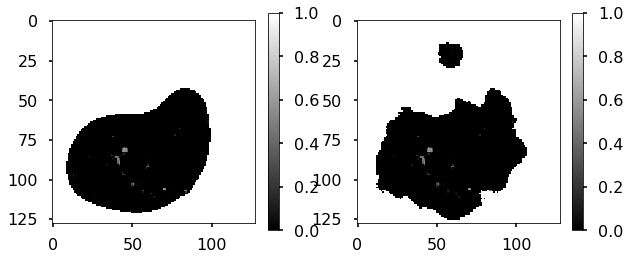

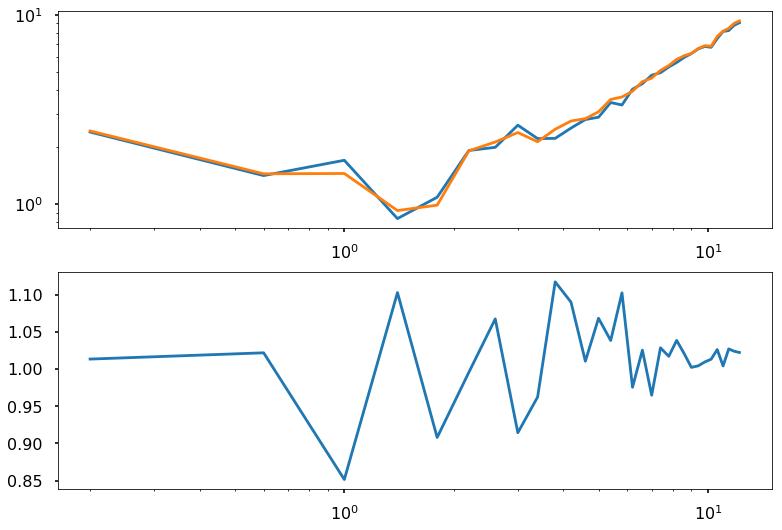

In [309]:
plt.figure(figsize=(10,4))


z = 7.
n_c = 2.5

ion7 = 1.0*(z_field<z)
ion7_mod = ion7.copy()

ion7_mod += 1.0-n_c*q**-0.5
ion7_mod[ion7==1]=1
ion7_mod[ion7_mod>1] = 1
ion7_mod[ion7_mod<0] = 0

ion7_distorted = 1.0*(z_field_distorted<z)
ion7_mod_distorted = ion7_distorted.copy()

ion7_mod_distorted += 1.0-n_c*q**-0.5
ion7_mod_distorted[ion7_distorted==1]=1
ion7_mod_distorted[ion7_mod_distorted>1] = 1
ion7_mod_distorted[ion7_mod_distorted<0] = 0


plt.figure(1)
plt.subplot(121)
plt.imshow(ion7_mod[0,:,:], cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.imshow(ion7_mod_distorted[0,:,:], cmap='gray')
plt.colorbar()

PS_HI_mod = pk((ion7_mod*q), boxsize, k_list_phys)
PS_HI_mod_distorted = pk((ion7_mod_distorted*q), boxsize, k_list_phys)

plt.figure(2)

plt.subplot(211)
plt.plot(k_list_phys_centers, PS_HI_mod*k_list_phys_centers**3)
plt.plot(k_list_phys_centers, PS_HI_mod_distorted*k_list_phys_centers**3)
plt.xscale('log')
plt.yscale('log')

plt.subplot(212)
plt.plot(k_list_phys_centers, PS_HI_mod_distorted / PS_HI_mod)
plt.xscale('log')
# plt.yscale('log')